# ***i. Introduction***
___
Authors      : Fhad Saleh 

Dataset   : Informasi tentang penggunaan listrik sebuah perusahaan manufaktur. [Dataset](power_consumption.csv) 

Objective : 
- Melakukan prediksi (forecasting) penggunaan listrik dalam 30 hari ke depan.
- forecasting akan dilakukan dengan model ARIMA & SARIMA.
- Metode yg digunakan untuk pada project ini adalah AIC, ACF & PACF
- Metrics evaluation yg digunakan untuk pada project ini adalah , MAE, MAPE & RMSE.

# ***ii. Import Libraries***
___
Mengimport semua library yang akan digunakan dalam project ini.

In [1]:
# import libraries
# library yg biasa digunakan untuk DA / DS
import pandas as pd
import matplotlib.pyplot as plt
import pylab
# library yg digunakan untuk timeseries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# library metrics yg digunakan
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

# ***iii. Data Loading***
___
Melakukan preparation untuk dataset yg akan digunakan.

In [2]:
# loading dataset
df = pd.read_csv('power_consumption.csv')
df

,Date,Power_Usage
0,2022-01-01,2379
1,2022-01-02,2480
2,2022-01-03,2350
3,2022-01-04,1841
4,2022-01-05,2462
...,...,...
543,2023-06-28,2621
544,2023-06-29,2553
545,2023-06-30,2326
546,2023-07-01,2461


In [3]:
# cek missing value
df.isnull().sum()

Date           0
Power_Usage    0
dtype: int64

In [4]:
# cek dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         548 non-null    object
 1   Power_Usage  548 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 8.7+ KB


In [5]:
# ubah tipe data kolom date dari object ke datetime
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
# cek pola interval date / cek frekuensi data
df['Date'].dt.freq

'D'

In [7]:
# ubah dataframe ke timeseries
dfts = df.set_index('Date')

In [8]:
# cek dataframe timeseries
dfts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 548 entries, 2022-01-01 to 2023-07-02
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Power_Usage  548 non-null    int64
dtypes: int64(1)
memory usage: 8.6 KB


In [9]:
# cek index timeseris
dfts.index

DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10',
               ...
               '2023-06-23', '2023-06-24', '2023-06-25', '2023-06-26',
               '2023-06-27', '2023-06-28', '2023-06-29', '2023-06-30',
               '2023-07-01', '2023-07-02'],
              dtype='datetime64[ns]', name='Date', length=548, freq=None)

# ***iv. Exploratory Data Analysis (EDA)***
___
Pada bagian ini akan dilakukan eksplorasi pada dataset yg sudah dicleansing dengan menggunakan query, grouping, visualisasi data sederhana dan sebagainya.


## EDA 1
### Karateristik

<Axes: xlabel='Date'>

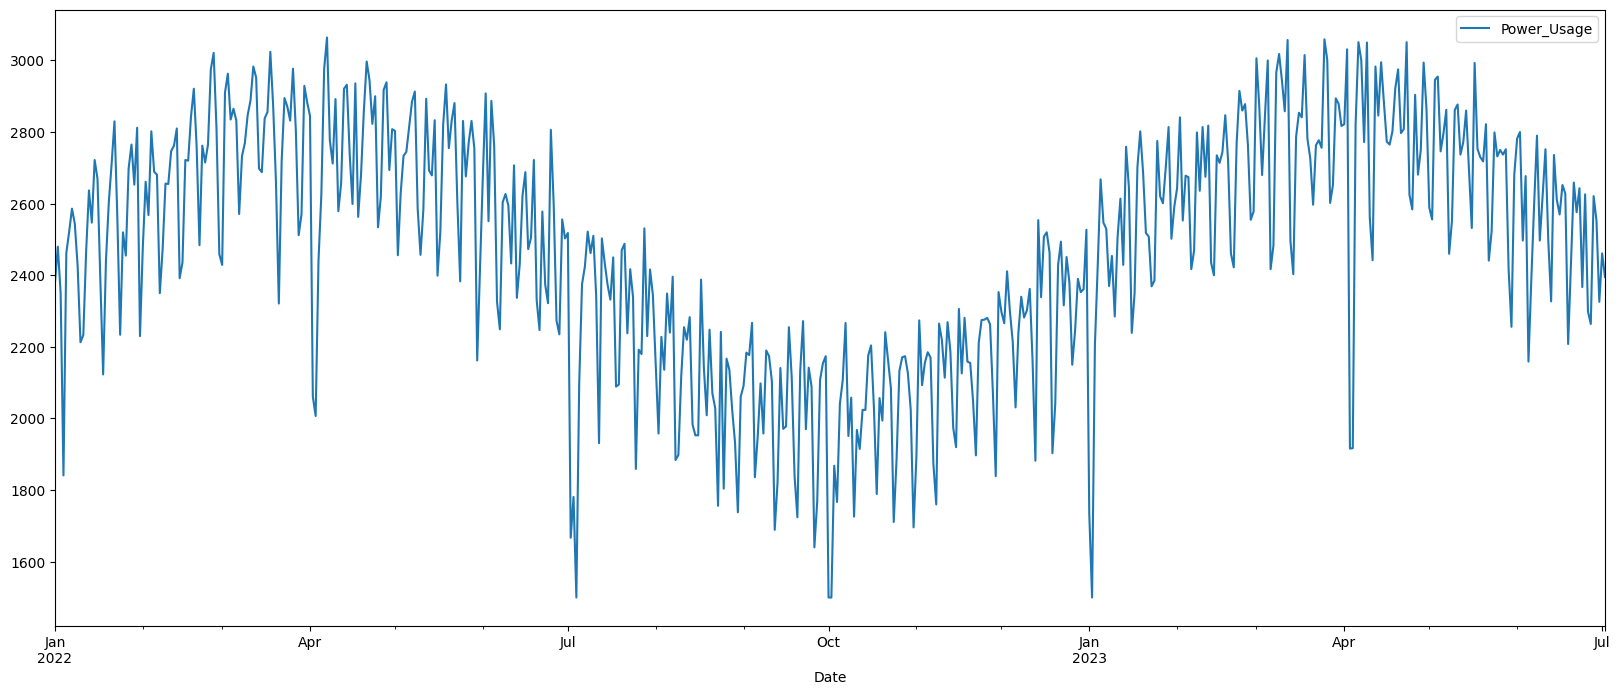

In [10]:
# visualisasi timeseries
dfts.plot(figsize=(20,8))

Terlihat data yg diambil adalah data dari bulan Januari, April, Jul, Oktober. Atau dengan kata lain data diambil per 3 bulan sekali. 

Dari visualisi terlihat bahwa dari bulan Januari ke bulan April pemakaian listrik meningkat, dan akan menurun dari April ke Juli sampai Oktober.

Pemakaian listrik tertinggi ada pada bulan April, dan yg terendah di bulan Oktober.

Dari visualisasi dapat terlihat bahwa terdapat seasonal pada data.

## EDA 2
### Decomposition

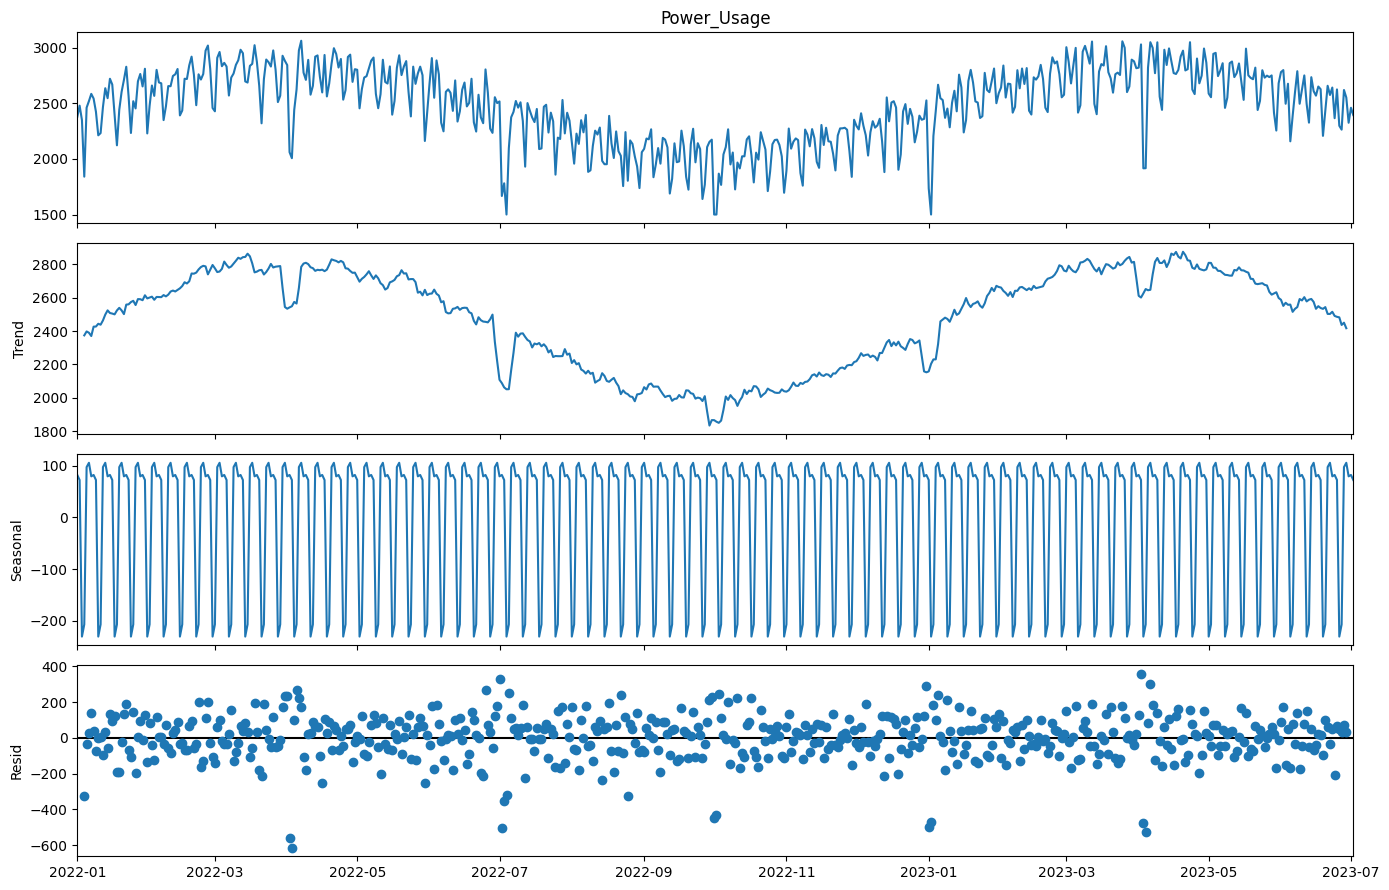

In [11]:
# decompostion additive
pylab.rcParams['figure.figsize'] = (14,9)
res = seasonal_decompose(dfts['Power_Usage'], model='additive')
ax = res.plot()
plt.show()

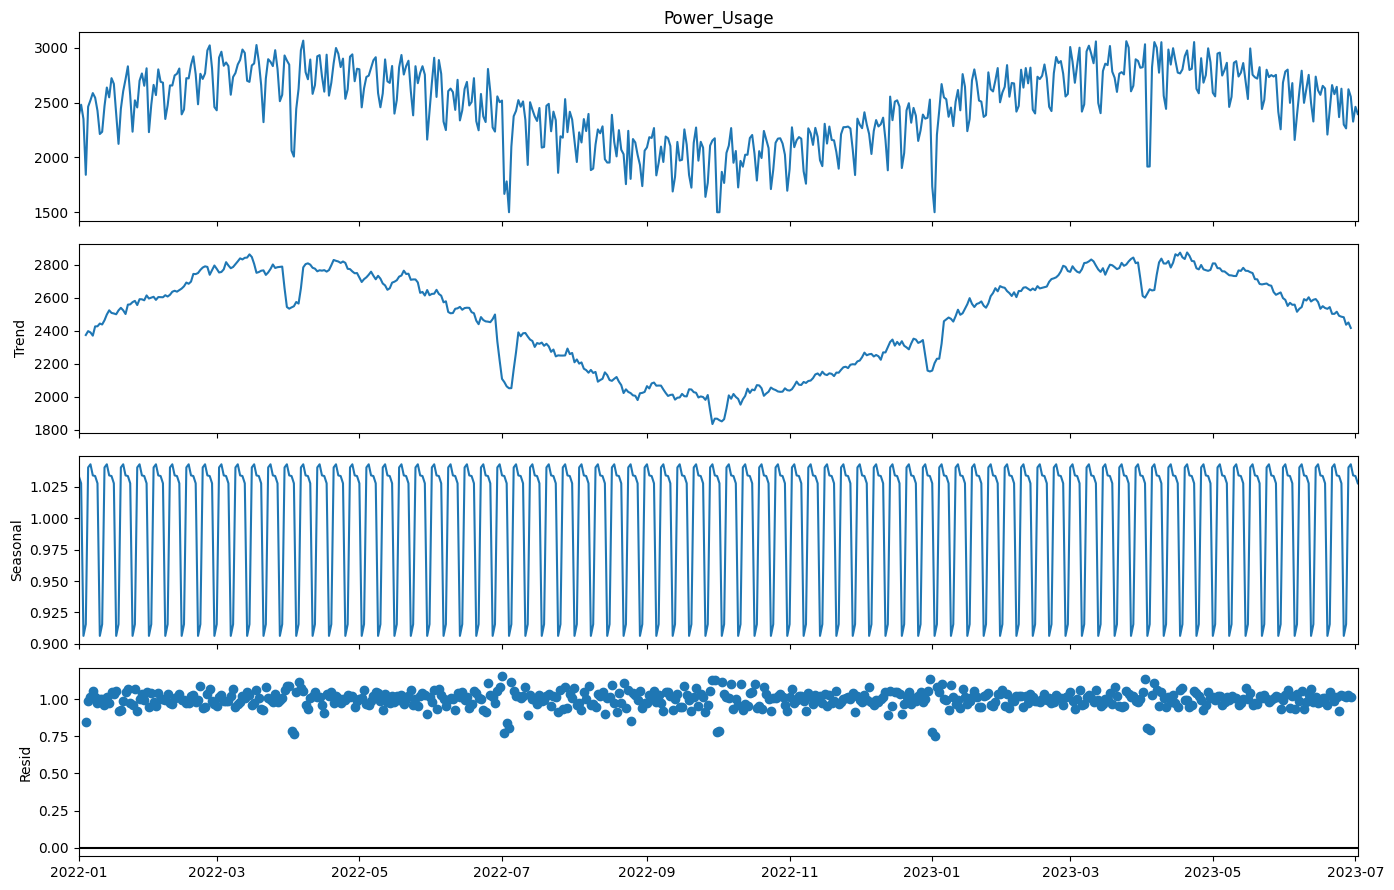

In [12]:
# decompostion multiplicatif
pylab.rcParams['figure.figsize'] = (14,9)
res = seasonal_decompose(dfts['Power_Usage'], model='multiplicatif')
ax = res.plot()
plt.show()

Dari visualisasi grafik dekomposisi additive & multiplicatif. Terlihat bahwa:
- Baik additive & multiplicatif memiliki kecenderung **trend** yg sama dengan nilai *peak* (tertinggi) yg sama.
- Dari grafik **seasonal** terlihat bahwa additive memiliki nilai *peak* di angka 100 dengan *range* (jarak) yg cukup beragam, dari `-200` sampai `100`. Sedangkan untuk multiplicatif nilai *peak* ada di angka `> 1.025` dengan *range* (jarak) dari `0.900` sampai `1.025`
- Untuk **residual** additive variansi datanya sangat beragam ada yg `< 0 & > 0`. Sedangkan multiplicatif semua variansi ada `> 0`

Jadi pada project kali ini akan digunakan seasonal dengan model ***Multiplicatif***.

In [13]:
# mengambil nilai seasonal pada data
res.seasonal

Date
2022-01-01    1.033412
2022-01-02    1.027626
2022-01-03    0.906405
2022-01-04    0.915646
2022-01-05    1.040236
                ...   
2023-06-28    1.040236
2023-06-29    1.042754
2023-06-30    1.033920
2023-07-01    1.033412
2023-07-02    1.027626
Name: seasonal, Length: 548, dtype: float64

In [14]:
# mencari nilai peak / tertinggi pada seasonal
v = pd.DataFrame(res.seasonal[res.seasonal == res.seasonal.max()])
v

,seasonal
Date,
2022-01-06,1.042754
2022-01-13,1.042754
2022-01-20,1.042754
2022-01-27,1.042754
2022-02-03,1.042754
...,...
2023-06-01,1.042754
2023-06-08,1.042754
2023-06-15,1.042754


In [15]:
# mencari frekuensi peak seasonal atau setiap tgl / hari apa nilai peak berada
pd.infer_freq(v.index)

'W-THU'

nilai S yg akan digunakan pada model adalah `S = 7` berdasarkan nilai *peak* yg ada pada setiap minggu di hari rabu (*Thursday*).

## EDA 3
### Stasionarity

In [16]:
# function untuk mengecek stasionarity
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [17]:
# check stasionarity basic
check_stationarity(dfts)

ADF Statistic: -1.203292
p-value: 0.672178
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
Non-stationary


In [18]:
# check stasionarity: 1st order differencing
check_stationarity(dfts.diff().dropna())

ADF Statistic: -7.271292
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
Stationary


Stasionarity didapatkan setelah melakukan *differencing pada 1st order*. Stasionarity dilakukan untuk mengasumsikan bahwa nilai interval antara data tidak mempengaruhi satu sama lain.

Nilai D yg akan dipakai pada model adalah `D = 1`.

## EDA 4
### ACF & PACF

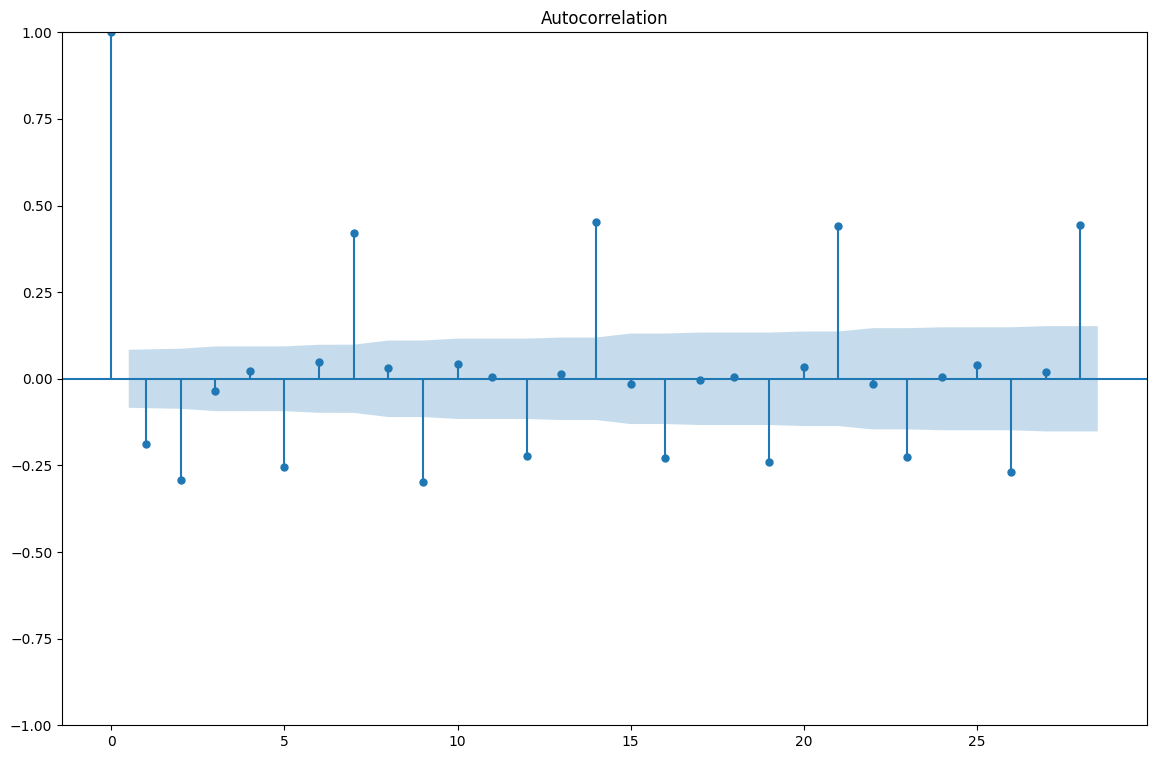

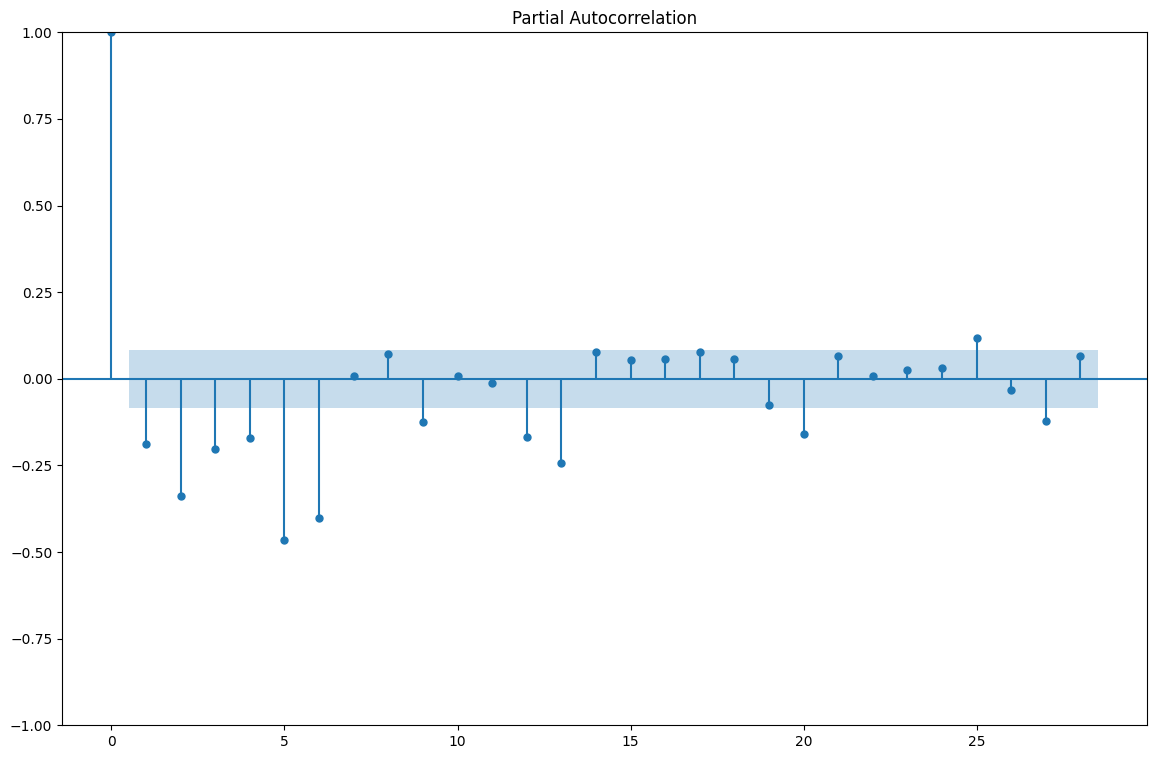

In [19]:
#  membuat grafik ACF & PACF
plot_acf(dfts.diff().dropna())
plot_pacf(dfts.diff().dropna())
plt.show()

- Dari grafik ACF ditemukan nilai `q = 2` hasil dari *cutoff*.
- Dari grafik PACF ditemukan nilai `p = 6` hasil dari *cutoff*.

### AIC
Menggunakan metode aic untuk menentukan nilai p, d, & q.

### Split Train & Test

In [20]:
dfts.shape

(548, 1)

In [21]:
# split data train set unuk pengujian
train = dfts[:400]
test = dfts[400:]

In [22]:
# pengujian model dengan ARIMA
testArima612 = ARIMA(train, order = (6,1,2))
testArima612 = testArima612.fit()

c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [23]:
# cek nilai aic
testArima612.aic

5284.663980673646

Setelah melakuakn pengujian dengan nilai `p = 2, d = 1, dan q = 6`, diperoleh nilai `aic = 5284.663980673646`. Nilai AIC masih terlalu besar dan model kemungkinan masih terlalu kompleks.

In [24]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [25]:
find_best_model(train, 6,1,2)

c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No f

(6,
 1,
 0,
 5281.75059847418,
     p  d  q          AIC
 39  6  1  0  5281.750598
 40  6  1  1  5283.572174
 41  6  1  2  5284.663981
 35  5  1  2  5290.583142
 34  5  1  1  5296.314071
 38  6  0  2  5305.099094
 37  6  0  1  5311.944658
 29  4  1  2  5328.191447
 33  5  1  0  5330.895024
 17  2  1  2  5334.264765
 28  4  1  1  5337.582815
 36  6  0  0  5344.281936
 22  3  1  1  5347.280942
 23  3  1  2  5352.403241
 16  2  1  1  5352.470171
 31  5  0  1  5353.522507
 5   0  1  2  5360.739349
 11  1  1  2  5362.722579
 25  4  0  1  5363.663154
 32  5  0  2  5366.976175
 19  3  0  1  5368.827423
 10  1  1  1  5372.883002
 8   1  0  2  5376.920937
 14  2  0  2  5378.904810
 13  2  0  1  5388.993858
 26  4  0  2  5401.151399
 20  3  0  2  5403.944605
 4   0  1  1  5409.081128
 27  4  1  0  5421.136994
 7   1  0  1  5425.177058
 30  5  0  0  5427.969992
 21  3  1  0  5432.958074
 24  4  0  0  5435.642326
 18  3  0  0  5447.131874
 15  2  1  0  5453.140033
 12  2  0  0  5463.114917
 6   1 

Setelah melakukan pencarian dengan pendekatan AIC. Nilai dengan AIC paling kecil / terbaik adalah `p = 6, d = 1, & q = 0.`

Jadi untuk nilai `p, d, & q` yg akan digunakan pada model adalah:
- p = 6
- d = 1
- q = 0

Berdasarkan dengan hasil yg diperoleh dari AIC.

## EDA 5
### Menentukan nilai P, D, Q untuk model SARIMA

In [26]:
# menngambil nilai seasonal
seasonal = dfts.loc[res.seasonal[res.seasonal == res.seasonal.max()].index]
seasonal

,Power_Usage
Date,
2022-01-06,2521
2022-01-13,2637
2022-01-20,2604
2022-01-27,2699
2022-02-03,2568
...,...
2023-06-01,2782
2023-06-08,2790
2023-06-15,2611


In [27]:
# check stasionarity
check_stationarity(seasonal)

ADF Statistic: -4.340636
p-value: 0.000377
Critical Values:
	1%: -3.534
	5%: -2.906
	10%: -2.591
Stationary


data seasonal sudah stasionarity. Jadi nilai `D = 0`

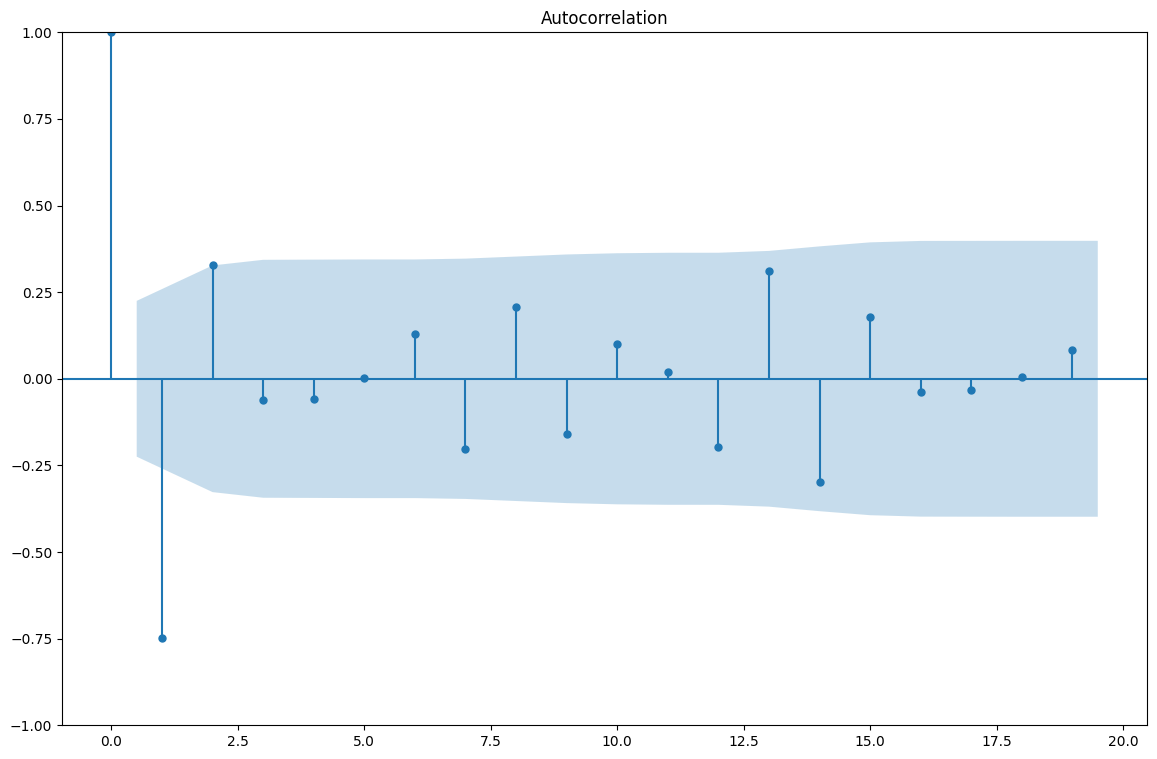

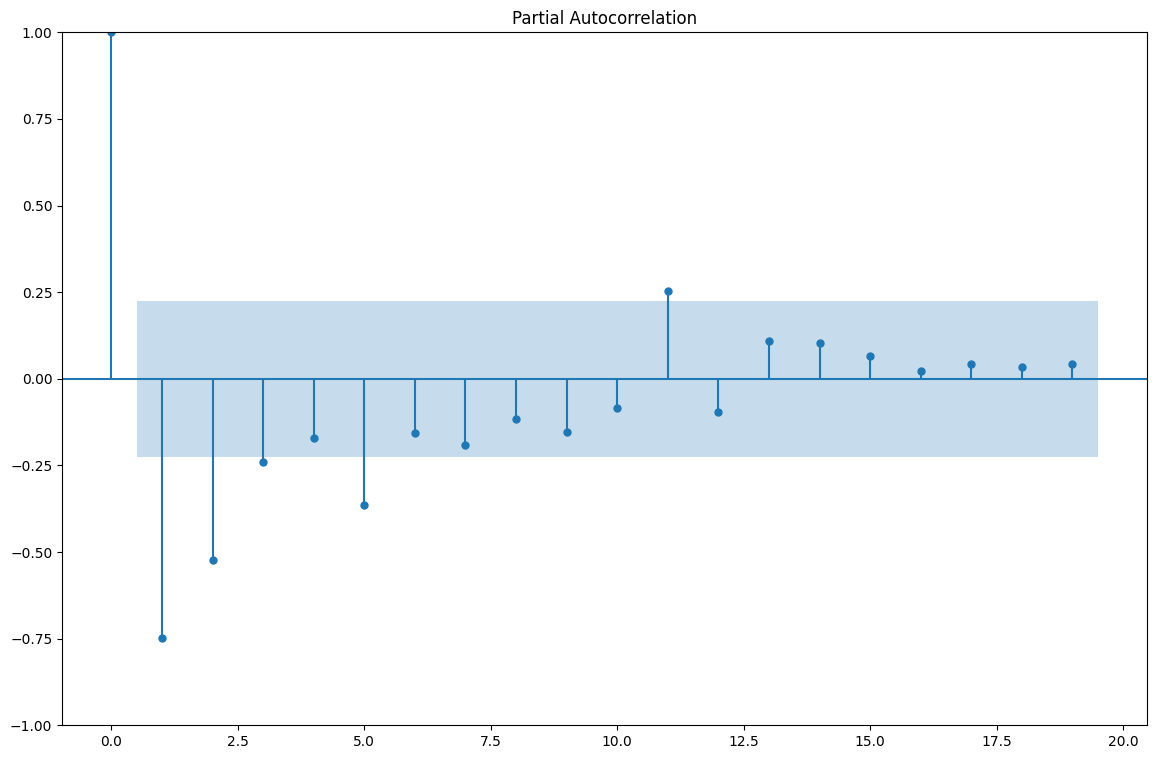

In [28]:
plot_acf(seasonal.diff().diff().dropna())
plot_pacf(seasonal.diff().diff().dropna())
plt.show()

- Dari grafik ACF ditemukan nilai `Q = 1` hasil dari *cutoff*.
- Dari grafik PACF ditemukan nilai `P = 3` hasil dari *cutoff*.

## Hasil dari EDA
- p = 6
- d = 1
- q = 0
- P = 3
- D = 0
- Q = 1
- s = 7

# ***v. Model Definition & Model Training***
___
***Model***: Model yg akan digunakan pada project kali ini adalah ARIMA & SARIMAX


In [29]:
# training model ARIMA 
arima = ARIMA(train, order = (6,1,0)).fit()

c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [30]:
# training model sarimax
sarimax = SARIMAX(train, order=(6,1,0), seasonal_order=(3,0,1,7)).fit()
sarimax.summary()

c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\HelasOn7\miniconda3\envs\h8_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         Power_Usage   No. Observations:                  400
Model:             SARIMAX(6, 1, 0)x(3, 0, [1], 7)   Log Likelihood               -2587.566
Date:                             Mon, 11 Aug 2025   AIC                           5197.132
Time:                                     12:07:17   BIC                           5241.011
Sample:                                 01-01-2022   HQIC                          5214.510
                                      - 02-04-2023                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6481      0.033    -19.451      0.000      -0.713      -0.583
ar.L2         -0.5721      0.040    -14.246      0.000      -0.651      -0.493
ar.L3         -0.5499      0.060     -9.158      0.000      -0.668      -0.432
ar.L4         -0.4517      0.058     -7.797      0.000      -0.565      -0.338
ar.L5         -0.3852      0.065     -5.890      0.000      -0.513      -0.257
ar.L6         -0.2561      0.062     -4.145      0.000      -0.377      -0.135
ar.S.L7        0.7491      0.080      9.411      0.000       0.593       0.905
ar.S.L14       0.2811      0.073      3.840      0.000       0.138       0.425
ar.S.L21      -0.0302      0.058     -0.522      0.602      -0.143       0.083
ma.S.L7       -0.9954      0.048    -20.709      0.000      -1.090      -0.901
sigma2      2.366e+04   2.64e-06   8.96e+09      0.000    2.37e+04    2.37e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               508.22
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -1.28
Prob(H) (two-sided):                  0.60   Kurtosis:                         7.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.39e+24. Standard errors may be unstable.
"""

# ***vi. Model Evaluation***
___
## Arimax


In [31]:
predTrainArima = arima.predict(start = train.index[0],
                                   end = train.index[-1])
predTestArima = arima.predict(start = test.index[0],
                                   end = test.index[-1])

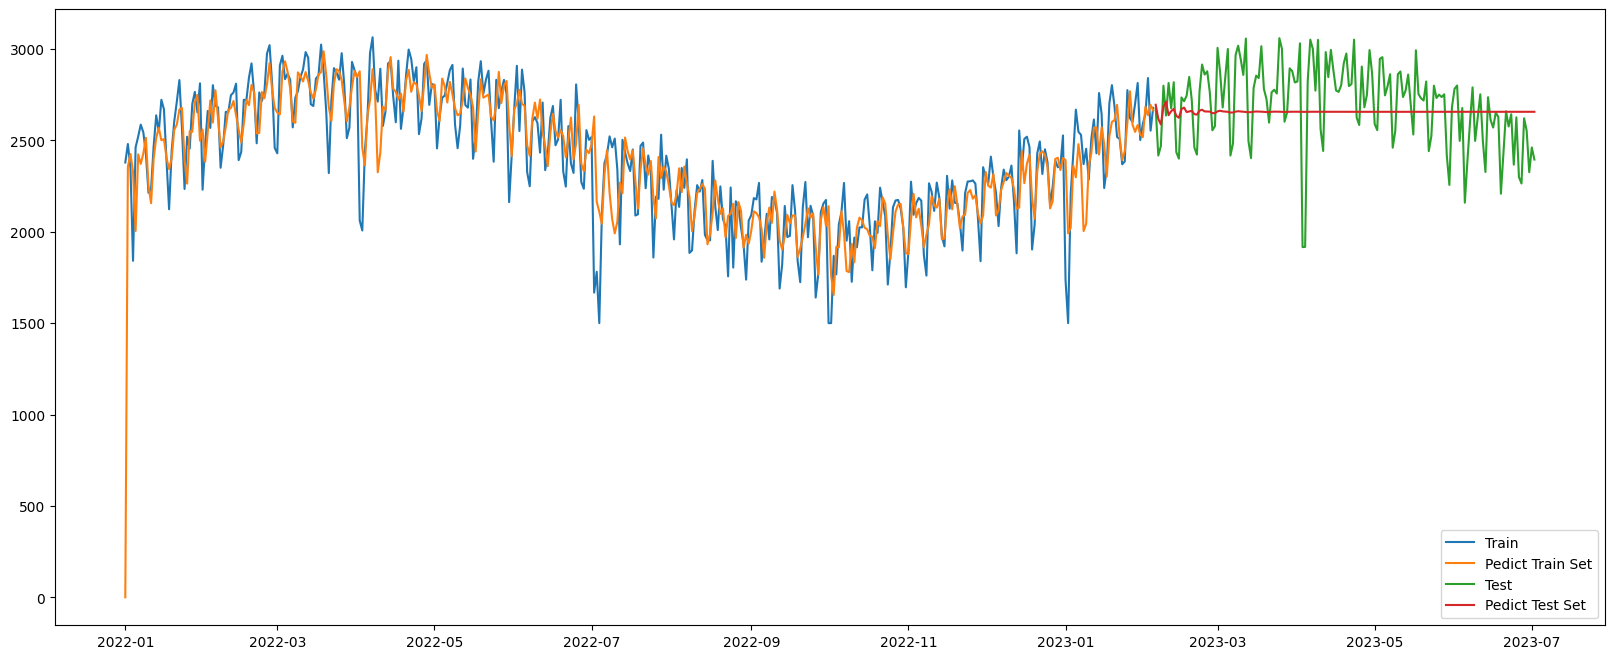

In [32]:
plt.figure(figsize=(20,8))
plt.plot(train['Power_Usage'], label='Train')
plt.plot(predTrainArima, label='Pedict Train Set')
plt.plot(test['Power_Usage'], label='Test')
plt.plot(predTestArima, label='Pedict Test Set')
plt.legend(loc='best')
plt.show()

In [33]:
# evaluasi metrics
print('Train Set')
print("mae :", mean_absolute_error(train['Power_Usage'], predTrainArima))
print("mape :", mean_absolute_percentage_error(train['Power_Usage'], predTrainArima))
print("rmse :", root_mean_squared_error(train['Power_Usage'], predTrainArima))
print('Test Set')
print("mae :", mean_absolute_error(test['Power_Usage'], predTestArima))
print("mape :", mean_absolute_percentage_error(test['Power_Usage'], predTestArima))
print("rmse :", root_mean_squared_error(test['Power_Usage'], predTestArima))

Train Set
mae : 136.30036699931927
mape : 0.06033881432888668
rmse : 214.51580327174392
Test Set
mae : 181.84721488135594
mape : 0.06882463326510142
rmse : 223.29364506510362


## SARIMAX

In [34]:
predtrainSar = sarimax.predict(start = train.index[0],
                                     end = train.index[-1])
predTestSar = sarimax.predict(start = test.index[0],
                                     end = test.index[-1])

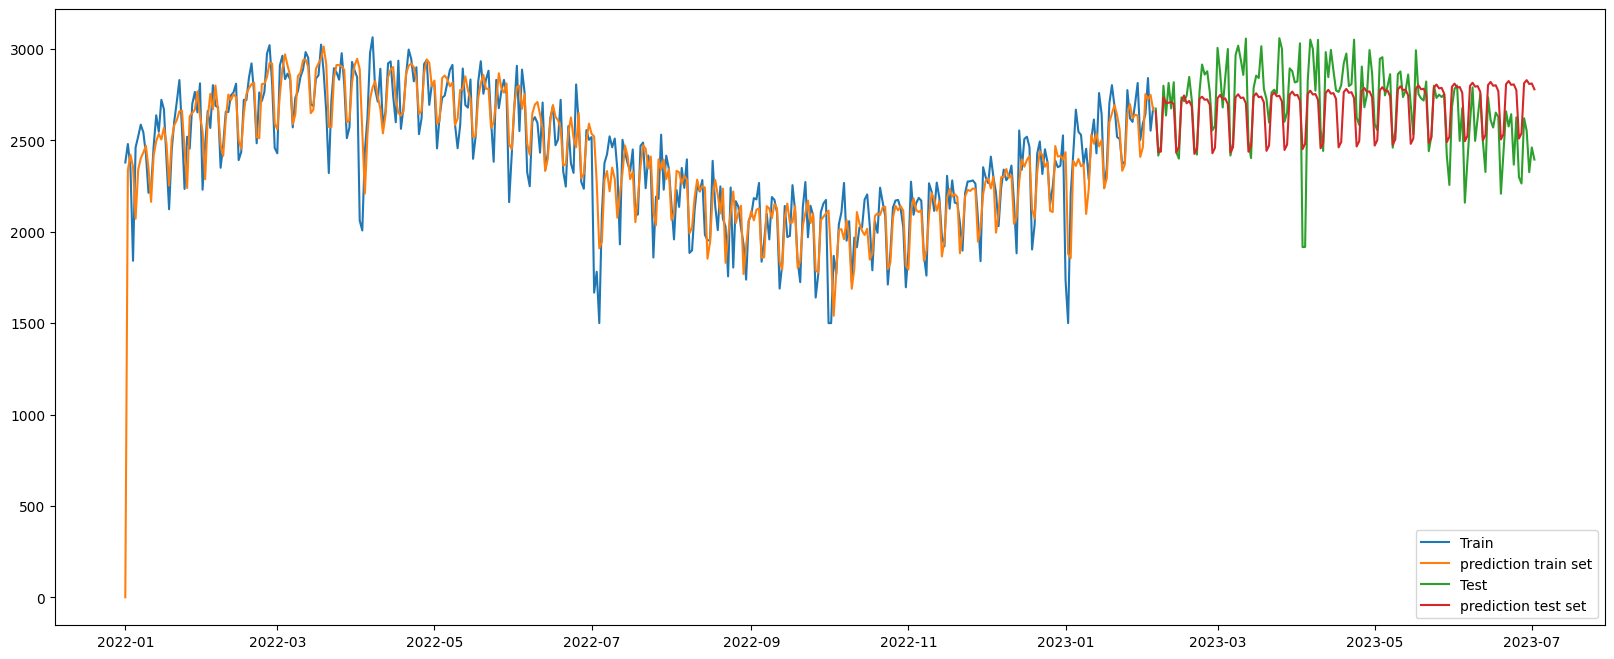

In [35]:
plt.figure(figsize=(20,8))
plt.plot( train['Power_Usage'], label='Train')
plt.plot( predtrainSar, label = 'prediction train set')
plt.plot(test['Power_Usage'], label='Test')
plt.plot( predTestSar, label = 'prediction test set')
plt.legend(loc='best')
plt.show()

In [36]:
# evaluasi metrics
print('SARIMAX Train Set')
print("mae :", mean_absolute_error(train['Power_Usage'], predtrainSar))
print("mape :", mean_absolute_percentage_error(train['Power_Usage'], predtrainSar))
print("rmse :", root_mean_squared_error(train['Power_Usage'], predtrainSar))
print('SARIMAX Test Set')
print("mae :", mean_absolute_error(test['Power_Usage'], predTestSar))
print("mape :", mean_absolute_percentage_error(test['Power_Usage'], predTestSar))
print("rmse :", root_mean_squared_error(test['Power_Usage'], predTestSar))

SARIMAX Train Set
mae : 121.34927532997172
mape : 0.05376881023135572
rmse : 198.47777878198823
SARIMAX Test Set
mae : 138.02771329082526
mape : 0.052359655803575524
rmse : 180.3142727828054


# ***vii. Model Inferensial***
___
## Arimax


In [37]:
inferenceArima = arima.forecast(steps=30)
print(inferenceArima)

2023-02-05    2694.885863
2023-02-06    2617.488758
2023-02-07    2587.514606
2023-02-08    2684.794072
2023-02-09    2711.601875
2023-02-10    2637.723619
2023-02-11    2659.462242
2023-02-12    2671.784259
2023-02-13    2634.183050
2023-02-14    2623.523334
2023-02-15    2670.719295
2023-02-16    2679.581301
2023-02-17    2654.895953
2023-02-18    2658.043388
2023-02-19    2661.386746
2023-02-20    2643.339810
2023-02-21    2641.072547
2023-02-22    2662.379625
2023-02-23    2667.577703
2023-02-24    2658.358978
2023-02-25    2657.925042
2023-02-26    2657.345021
2023-02-27    2648.913535
2023-02-28    2648.858806
2023-03-01    2658.806241
2023-03-02    2662.061179
2023-03-03    2658.598287
2023-03-04    2657.572168
2023-03-05    2656.107074
2023-03-06    2652.099313
Freq: D, Name: predicted_mean, dtype: float64


In [38]:
inferenceSarimax = sarimax.forecast(steps=30)
print(inferenceSarimax)

2023-02-05    2658.452521
2023-02-06    2436.279633
2023-02-07    2438.453068
2023-02-08    2735.106882
2023-02-09    2704.174697
2023-02-10    2705.812508
2023-02-11    2710.492331
2023-02-12    2698.381373
2023-02-13    2432.497919
2023-02-14    2464.485682
2023-02-15    2715.798896
2023-02-16    2745.541163
2023-02-17    2702.854405
2023-02-18    2715.734482
2023-02-19    2685.703401
2023-02-20    2426.026847
2023-02-21    2451.828343
2023-02-22    2728.392318
2023-02-23    2738.538902
2023-02-24    2722.044922
2023-02-25    2724.308309
2023-02-26    2694.647746
2023-02-27    2429.607563
2023-02-28    2459.174409
2023-03-01    2730.133112
2023-03-02    2748.524480
2023-03-03    2725.288509
2023-03-04    2729.173721
2023-03-05    2697.406310
2023-03-06    2433.132659
Freq: D, Name: predicted_mean, dtype: float64
